#  Tensor decomposition techniques: Selling's algorithm

This notebook presents some tensor decomposition techniques that are at the foundation of our anisotropic PDE discretizations on cartesian grids. The general objective is to write a given symmetric positive definite matrix $D$ under the form
$$
    D = \sum_{0 \leq i < I} \lambda_i e_i e_i^T. 
$$
From this point, various numerical schemes can be designed, for both first order and second order, and both linear and non-linear PDEs.

The techniques used for constructing the above decomposition are non-trivial, and are related to classical yet subtle tools of discrete geometry. This notebook is meant to illustrate some of their properties.

This notebook is limited to dimensions $d\in \{2,3\}$. Tensor decomposition in dimension $d \in \{4,5\}$ requires another set of techniques (and in practice the call to a c++ library), which are discussed in [II Tensor decomposition, dimensions 4 and 5](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/AdaptiveGridDiscretizations/master/Notebooks/TensorVoronoi.ipynb)

*Summary of this series of notebooks:*
[Adaptive grid discretizations, summary](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/AdaptiveGridDiscretizations/master/Notebooks/Summary.ipynb)

**Acknowledgement** 

The experiments presented in this notebook are part of ongoing research, with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans.

**References**

The tensor decomposition presented in this notebook is a central ingredient of the following paper:

Fehrenbach, J., & Mirebeau, J.-M. (2014). Sparse non-negative stencils for anisotropic diffusion. Journal of Mathematical Imaging and Vision, 49(1), 123–147. http://doi.org/http://dx.doi.org/10.1007/s10851-013-0446-3





## 0. Importing the required libraries

In [1]:
import sys; sys.path.append("..") # Allow import from parent directory
from NumericalSchemes import LinearParallel as lp
from NumericalSchemes import Selling

The library imported as **lp** is a set of routines meant to facilitate the manipulation of *numerous small vectors and matrices* simultaneously. It is based on numpy and implements  only a small number of linear algebra tools.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import importlib
lp=importlib.reload(lp)
Selling = importlib.reload(Selling)

## 1. Decomposing a tensor, or a tensor field

In order to illustrate our tensor decomposition facilities, we will rely on randomly generated *symmetric positive definite* tensors. They are built as 
$$
    M = A^T A
$$
where $A$ has normalized random gaussian entries.

In [4]:
def MakeRandomTensor(dim,shape = tuple()):
    A = np.random.standard_normal( (dim,dim) + shape )
    return lp.dot_AA(lp.transpose(A),A)

In [5]:
# For reproducibility, we fix the random seed
np.random.seed(42) 

## 1.1 Case of a $2\times 2$ matrix 


In [6]:
# Generate a 2x2 random psd tensor
D2 = MakeRandomTensor(2)

The **Selling.Decomposition** routine, applies to a symmetric positive definite matrix $D$ of size $d \times d$, with $d\leq 3$. It returns coefficients $\lambda_i \geq 0$ and offsets $e_i \in Z^d$.

A discussion on the inner workings of this decomposition is presented in the next section.

In [7]:
coefs,offsets = Selling.Decomposition(D2)

The matrix can be reconstructed by the formula
$$
    D = \sum_{0 \leq i < I} \lambda_i e_i e_i^T. 
$$

In [8]:
def Reconstruct(coefs,offsets):
     return lp.mult(coefs,lp.outer_self(offsets)).sum(2)
    
def LInfNorm(a):
    return np.max(np.abs(a))

In [9]:
print("Reconstruction error : ", LInfNorm(D2-Reconstruct(coefs,offsets)) )

Reconstruction error :  0.0


There are $I = d(d+1)/2$ coefficients and offsets (a.k.a $I=3$ if $d=2$, and $I=6$ if $d=3$). Note that this is more than the similar-looking eigen-decomposition of a matrix, which uses only $d$ coefficients and unit vectors. However, our offsets have integer entries, hence are suitable for the construction of finite difference schemes.

In [15]:
print("Selling decomposition of matrix : \n", D2)
print("Coefficients : ", coefs)
print("Offsets : \n", offsets.astype(int))

Selling decomposition of matrix : 
 [[0.66622539 0.91777115]
 [0.91777115 2.33873696]]
Coefficients :  [0.41467964 0.91787431 0.25154575]
Offsets : 
 [[-1  0  1]
 [-1 -1  2]]


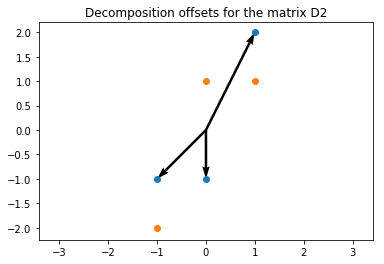

In [16]:
plt.axis('equal'); plt.title("Decomposition offsets for the matrix D2")
plt.quiver(*np.zeros(offsets.shape),*offsets,angles='xy',scale_units='xy',scale=1);
plt.scatter(*offsets); plt.scatter(*(-offsets));

## 1.2 Case of a $3 \times 3$ matrix.

As previously, we generate a 3x3 random psd tensor, decompose it and validate the absence of reconstruction error.

In [17]:
D3 = MakeRandomTensor(3)

In [18]:
coefs,offsets = Selling.Decomposition(D3)

In [19]:
print("Reconstruction error : ", LInfNorm(D3-Reconstruct(coefs,offsets)) )

Reconstruction error :  1.1102230246251565e-16


In [20]:
print("Selling decomposition of matrix : \n", D3)
print("Coefficients : ", coefs)
print("Offsets : \n", offsets.astype(int))

Selling decomposition of matrix : 
 [[ 0.85853982 -0.08963958 -0.06552819]
 [-0.08963958  0.49213052 -0.73715916]
 [-0.06552819 -0.73715916  2.84683026]]
Coefficients :  [0.15516777 0.08963958 0.61373247 0.24502864 1.46444606 0.1574623 ]
Offsets : 
 [[-1  1 -1  0  0  0]
 [ 0 -1  0  1  0 -1]
 [ 1  1  0 -2  1  1]]


### 1.1 Cases of (extremely) strong anisotropy

Selling's tensor decomposition algorithm requires the matrix to be positive definite. It involves a loop, which number of iterations explodes as the matrix degenerates.

A maximum number of iterations is set by default, to a reasonably large value, so that non-convergence is typically due to an error on the user's side - namely a non-positive matrix. 

In [21]:
# Construct some matrix with extremely large condition number
eps = 1/200.
D2_bad = np.array([[1,eps],[eps,2*eps**2]])

In [22]:
#Selling's decomposition does not terminate within the iteration limit
try:
    coefs,offsets = Selling.Decomposition(D2_bad)
except ValueError as e:
    print(e.args)

('Selling.Decomposition2 error: Selling algorithm unterminated',)


The iteration limit of Selling's algorithm may be increase, so as to ensure correct termination.

In [23]:
Selling.iterMax2 *= 2

In [24]:
coefs,offsets = Selling.Decomposition(D2_bad)

However, the resulting offsets are unlikely to be of use for any PDE discretization, since they are way too large. 

Note also than basis reduction techniques more efficient than Selling's algorithm are available for tensors with extremely large condition numbers. (E.g. Lagrange's algorithm.)

In [25]:
print("offsets : \n", offsets.astype(int))

offsets : 
 [[-99 100  -1]
 [ -1   1   0]]


### 1.2 Decomposition a field of symmetric tensors

Our implementation of Selling's algorithm automatically threads over dimensions deeper than two.

In [26]:
# Generate a 10x10 field of random 2x2 spd tensors
D2_field = MakeRandomTensor(2,(10,10))

In [27]:
coefs, offsets = Selling.Decomposition(D2_field)

In [28]:
print("Max reconstruction error : ", LInfNorm(D2_field - Reconstruct(coefs,offsets)))

Max reconstruction error :  3.9523939676655573e-13


## 2. Under the hood : obtuse superbases

This section illustrates the main mathematical concept underlying Selling's decomposition, known as *obtuse superbases* of the lattice $Z^d$.

A superbase of $Z^d$ is a special kind of coordinate system $(b_0,\cdots,b_d)$, spanning the lattice of integer points and with some redundancy. More precisely, one requires
$$
\begin{aligned}
    b_0+\cdots+b_d &= 0\\
    \det(b_1,\cdots,b_d) &= \pm 1
\end{aligned}
$$
Obtuseness is a geometrical property, related to the tensor being decomposed, and illustrated below.

### 2.1 Two dimensions

We first generate an arbitrary superbase.

In [29]:
sb = Selling.CanonicalSuperbase(2)

In [30]:
print(sb.astype(int))

[[-1  1  0]
 [-1  0  1]]


Given a positive definite tensor $D$, and an arbitrary superbase, Selling's algorithm will modify the latter until a geometrical condition is met.

In [31]:
# Returned value tells wether the algorithm stabilized before the iteration limit.
Selling.ObtuseSuperbase2(D2,sb)

True

In [32]:
print(sb.astype(int))

[[-1 -1  2]
 [ 1  0 -1]]


The modified superbase $(b_0,\cdots,b_d)$ is designed to be $D$-obtuse. In other words to obey 
$$
    <b_i,D b_j> \leq 0
$$
for all distinct $i,j\in \{0,1,2\}$.

In [33]:
print([lp.dot_VAV(sb[:,i],D2,sb[:,np.mod(i+1,3)]) for i in range(3)])

[-0.251545753744008, -0.4146796384446705, -0.9178743070679038]


The tensor decomposition reads 
$$
    D = -\sum_{0\leq i<j \leq d} <b_i,D b_j> v_{ij} v_{ij}^\perp,
$$
where one defines $v_{ij} = b_k^\perp$ where $\{i,j,k\} = \{0,1,2\}$. 

In particular, 
* the weight of the decomposition are the negated scalar products.
* the offsets of the decomposition are the superbase elements rotated by $\pi/2$.

In [34]:
coefs,offsets = Selling.Decomposition(D2)

In [35]:
print("Coefficients : ", coefs)
print("Offsets : \n", offsets.astype(int))

Coefficients :  [0.41467964 0.91787431 0.25154575]
Offsets : 
 [[-1  0  1]
 [-1 -1  2]]


### 2.2 Three dimensions

We follow similar steps in dimension $d=3$.

In [36]:
sb = Selling.CanonicalSuperbase(3)

In [37]:
print(sb.astype(int))

[[-1  1  0  0]
 [-1  0  1  0]
 [-1  0  0  1]]


In [38]:
Selling.ObtuseSuperbase3(D3,sb)

True

In [39]:
print(sb.astype(int))

[[ 1  0  0 -1]
 [ 0  1  1 -2]
 [ 0  1  0 -1]]


The superbase, once updated by Selling's algorithm, is again $D$-obtuse as in two dimensions.

In [40]:
print([lp.dot_VAV(sb[:,i],D3,sb[:,j]) for i in range(4) for j in range(i)])

[-0.15516776941907545, -0.08963958172347006, -0.2450286383841236, -0.6137324732734054, -1.4644460568297009, -0.1574622969114413]


The tensor decomposition reads 
$$
    D = -\sum_{0\leq i<j \leq d} <b_i,D b_j> v_{ij} v_{ij}^\perp,
$$
where one defines $v_{ij} = \pm b_k \wedge bl$ where $\{i,j,k,l\} = \{0,1,2,3\}$. 

In particular, 
* the weight of the decomposition are the negated scalar products.
* the offsets of the decomposition are the cross-products of superbase elements (or their oppossites)

In [41]:
coefs,offsets = Selling.Decomposition(D3)

In [42]:
print("Coefficients : ", coefs)
print("Offsets : \n", offsets.astype(int))

Coefficients :  [0.15516777 0.08963958 0.61373247 0.24502864 1.46444606 0.1574623 ]
Offsets : 
 [[-1  1 -1  0  0  0]
 [ 0 -1  0  1  0 -1]
 [ 1  1  0 -2  1  1]]


In [43]:
#Comparing with the cross products of the superbase elements.
print(np.array(
    [lp.cross(sb[:,i],sb[:,j]) for i in range(4) for j in range(i)]
).astype(int))

[[ 0  1 -1]
 [ 0  0 -1]
 [ 1  0  0]
 [ 0 -1  2]
 [-1  1 -1]
 [ 1  0 -1]]


## 3 Properties of the decomposition

Selling's decomposition of tensors, presented in this notebook has a qualities that make it particularly suitable for PDE discretizations. More precisely, it is:
* *Local*: The offsets appearing in the decomposition are typically small, and in any case bounded by the condition number of the tensor.
* *Stable*: The decomposition is unique, up to trivial transformations (reordering the offsets, and replacing some with their opposites). It is also stable, more precisely locally Lipschitz w.r.t. the decomposed tensor.  
* *Spanning* The offsets span $Z^d$ by linear relations with integer coordinates. In practice, this means that anisotropic PDE discretizations using this method should not produce chessboard artifacts. 


We illustrate these properties in dimension $d=2$, by considering a rotating family of tensors with fixed condition number. For any positive definite tensor $D$ we let 
$$
    \mu(D) := \sqrt{\|D\| \|D^{-1}\|}
$$ 
denote the anisotropy ratio, i.e. the sqrt of the condition number of $D$.

In [44]:
theta = np.linspace(0,np.pi/2,100)
mu = 10
D2_rotating = (
    mu**2 * lp.outer_self(np.array([np.cos(theta),np.sin(theta)])) 
    + lp.outer_self(np.array([-np.sin(theta),np.cos(theta)])) 
)

In [45]:
coefs,offsets = Selling.Decomposition(D2_rotating)

### 3.1 Offsets smallness 

The offsets $(e_i)_{1 \leq i \leq I}$ involved in Selling's decomposition of a tensor $D$ obey
$$
    \|e_i\| \leq C \mu(D),
$$
where $C$ is an absolute constant. 

In [46]:
offsets_norms = np.sqrt(np.sum(offsets**2,axis=0))

In [47]:
print("Sqrt of condition number : ", mu)
print("Largest offset norm : ", np.max(offsets_norms))

Sqrt of condition number :  10
Largest offset norm :  5.0990195135927845


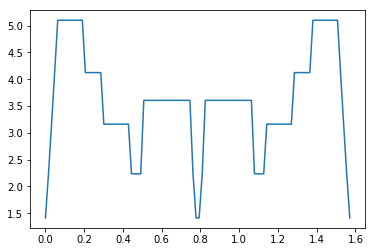

In [48]:
plt.plot(theta,np.max(offsets_norms,axis=0));

### 3.2 Stability

We may rewrite Selling's decomposition in an indexation independent manner, as follows
$$
    D = \sum_{e \in Z^d} \lambda^e(D) e e^T.
$$
One can the prove that the coefficient $\lambda^e(D)$ of Selling's tensor decomposition, for a given offset $e \in Z^d$, depends continuously on the parameter $D$, as illustrated below. 

In [49]:
decomp = Selling.GatherByOffset(theta,coefs,offsets)

**TODO** Figure out how to put a legend with the offsets

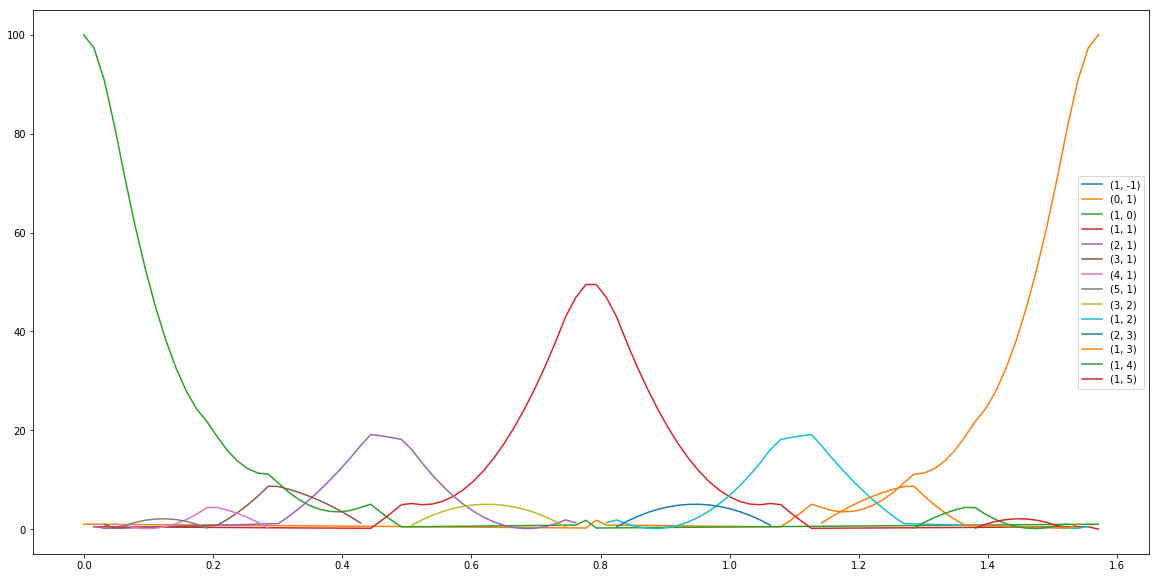

In [50]:
plt.figure(figsize=(20,10))
for offset,(angle,coef) in decomp.items():
    plt.plot(angle,coef)
plt.legend(decomp.keys());

### 3.3 Spanning property (no chessboard artifacts)

The lattice $Z^d$ is spanned, by integer combinations, by the offsets $(e_i)_{1 \leq i \leq I}$ appearing in the decomposition of an arbitrary p.s.d. tensor $D$. In other words, for all $x \in Z^d$, there exists coefficisnts $k_1,\cdots, k_I \in Z$ such that 
$$
    x = k_1 e_1 + \cdots+ k_d e_d.
$$
In addition, one may select this decomposition so that the weight $\lambda_i$ of $e_i$ is positive whenever $k_i \neq 0$.

This property guarantees that the graph underlying e.g. the discretization of an anisotropic laplacian is locally connected, hence that spurious modes such as chessboard artifacts will not appear. 

From a mathematical standpoint, the spanning property can be deduced from the construction of the decomposition in terms of obtuse superbases. Numerically, we can check it by finding a subset of the offsets whose determinant equals $\pm 1$. 

In [51]:
print( lp.det(offsets[:,0:2]) )

[ 1  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1 -1 -1 -1 -1 -1
 -1 -1 -1 -1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  1 -1  1 -1]


In [52]:
coefs,offsets = Selling.Decomposition(D3)

In [53]:
print(lp.det(offsets[:,0:3]))

-1
